# DAT200 CA5 2022

Kaggle username: Ivar Holmlund

### Imports

In [1]:
import time
start = time.time()
import pandas as pd
import numpy as np
import seaborn as sns
import csv
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import numpy as np
import matplotlib.pyplot as plt

import time

### Reading data

##### Training data

In [21]:
df = pd.read_pickle('train.pkl')
df = df.replace('missing', np.nan) #Replaces missing with numpy nan and changes dtypes to float and int
df = pd.get_dummies(data=df, columns = ['Weather situation', 'Season'], drop_first = True)
df = df.fillna(df.median())
X = np.array(df.loc[:, df.columns != 'Rental bikes count'])
y = np.array(df['Rental bikes count'])

##### Test data

In [3]:
df_test = pd.read_pickle('test.pkl')

df_test = pd.get_dummies(data=df_test, columns = ['Weather situation', 'Season'], drop_first = True)
df_test = df_test.replace('missing', np.nan) #Replaces missing with numpy nan and changes dtypes to float and int

df_test = df_test.fillna(df.median())

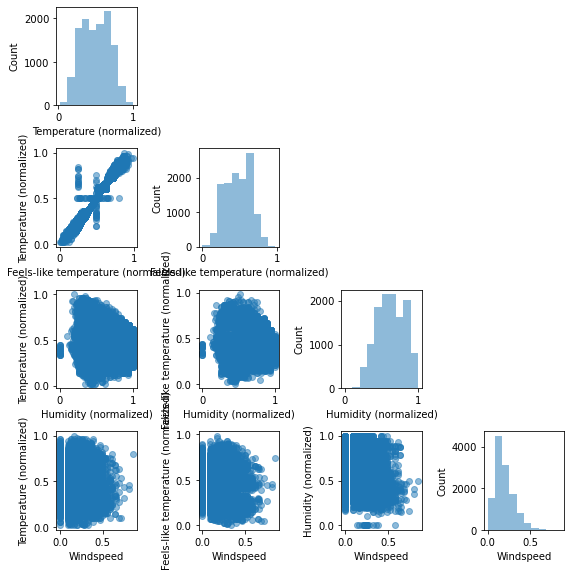

In [4]:
from mlxtend.plotting import scatterplotmatrix
cols = df.columns[6:10]
scatterplotmatrix(df.iloc[:, 6: 10].values, figsize=(8, 8),
                     alpha=0.5, names = cols);
plt.tight_layout()

### Data exploration and visualisation

Only visualising non-binary dataseries from dataset
The first columns for time, year and so on are not included. Rental bikes count has been excluded due to 
high value compared.

#### Interpretation from plot

- Values are fairly normally distributed.
- Some values seem to be below zero or above 1, which is not meant to happen since data has been normalized. 
  Those values will be removed in cell below
- Both data set look quite similar.

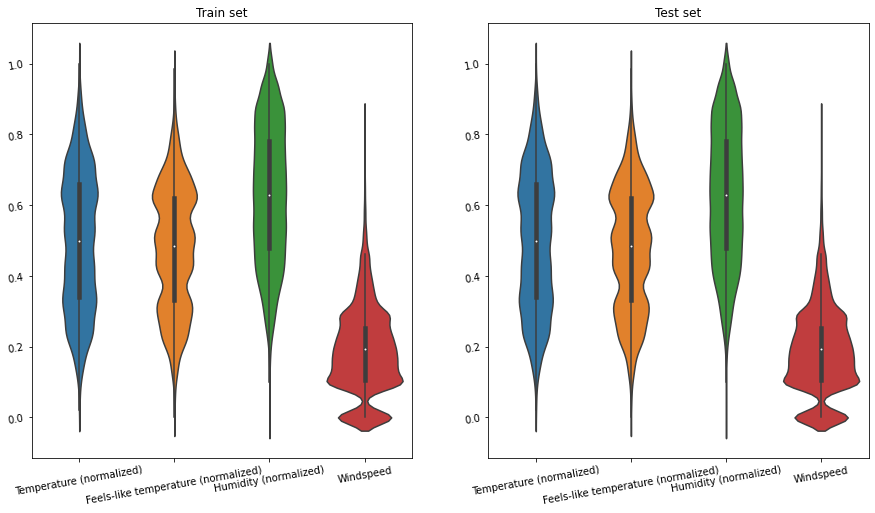

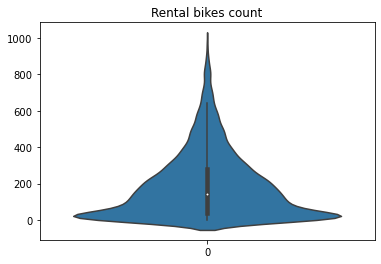

In [5]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.violinplot(data=df.iloc[:, 6: 10], ax=axes[0])
sns.violinplot(data=df.iloc[:, 6: 10], ax= axes[1])
headlines = ['Train set', 'Test set']
for ax, header in zip(figure.axes, headlines):
    ax.tick_params(labelrotation=10)
    ax.set_title(header)
plt.show()

sns.violinplot(data=df['Rental bikes count'])
plt.title('Rental bikes count')
plt.show()

### Data cleaning
Commented out the data cleaning since it did not boost performance.

In [6]:
initial_size = df.shape

#for name in df.iloc[:, 6:10].columns:
#    df_strip[name] = df[name].between(0, 1)

#df.drop(df.loc[df["Rental bikes count"] < 700], axis=1)

df = df[df['Rental bikes count'].between(0, 800)]
print(f'Initial shape:\t{initial_size}\nAfter removing:\t{df.shape}')

Initial shape:	(12165, 17)
After removing:	(12064, 17)


### Data exploration after cleaning

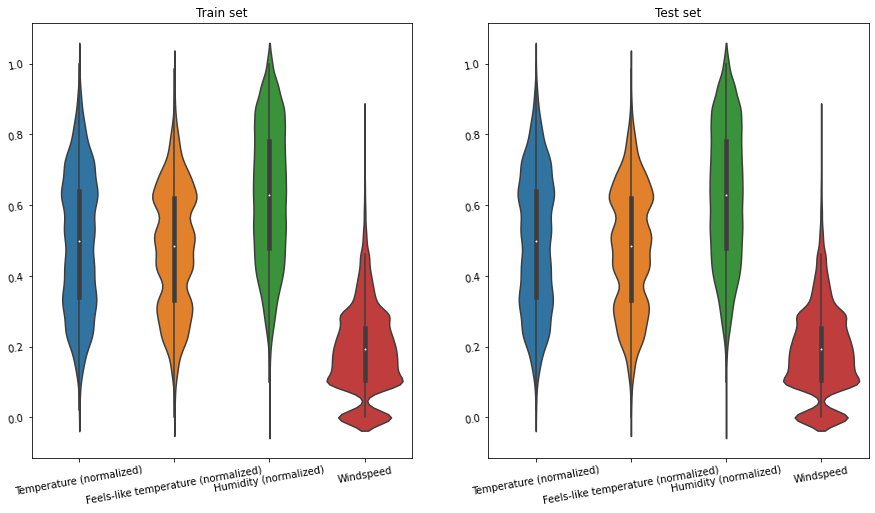

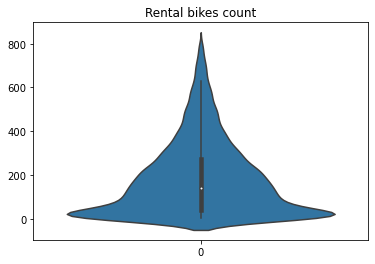

In [7]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.violinplot(data=df.iloc[:, 6: 10], ax=axes[0])
sns.violinplot(data=df.iloc[:, 6: 10], ax= axes[1])
headlines = ['Train set', 'Test set']
for ax, header in zip(figure.axes, headlines):
    ax.tick_params(labelrotation=10)
    ax.set_title(header)
plt.show()

sns.violinplot(data=df['Rental bikes count'])
plt.title('Rental bikes count')
plt.show()

### Data preprocessing

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)

#### Feature selection

- Using sklearns SequentialFeatureSelector(SFS) to eliminate columns with random noise.
- Cross-validating ten times to ensure reliable results

In [9]:
forest = RandomForestRegressor(n_estimators = 500,
                              random_state=1)

sfs1 = SFS(forest, 
           k_features=2, 
           forward=False, 
           floating=False, 
           verbose=0,
           scoring='r2',
           cv=2) 

# Fit models
sfs1 = sfs1.fit(X_train, y_train)
print(2)

# This dictionary contains results from all compuations
metricDict = sfs1.get_metric_dict()

2


#### Plotting results from SFS

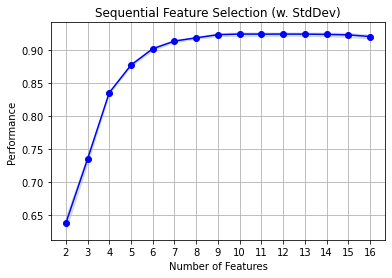

In [10]:
fig1 = plot_sfs(metricDict, kind='std_dev')

plt.title('Sequential Feature Selection (w. StdDev)')
plt.grid()
plt.show()

#### Saving most valuable columns in a list to use on df

In [15]:
cols = list(metricDict[7]['feature_names'])
print(*cols)
cols = [int(i) for i in cols]

0 1 2 4 5 6 8


#### Train test split on columns from SFS

In [25]:
X_sfs = df.iloc[:,cols]
X_test_sfs = df_test.iloc[:, cols]



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


### Modelling

#### Data pipeline with regression model

In [27]:
forest = RandomForestRegressor(n_estimators = 2000,
                              random_state=82)
forest_pipe = make_pipeline(forest)

forest.fit(X_sfs, y)

pred = forest.predict(X_test_sfs)

df_deliver = pd.DataFrame(pred, columns = ['Rental bikes count'])
df_deliver.to_csv('Deliverable_randforestregressor.csv')

#### Data pipeline with classification model

##### Binning train target values

Can be performed with ex. pandas.qcut or pandas.cut

```python
n_bins = 10
y_train_binned = pd.cut(y_train, n_bins, labels=False) # or
y_train_binned = pd.qcut(y_train, n_bins, labels=False) 
```

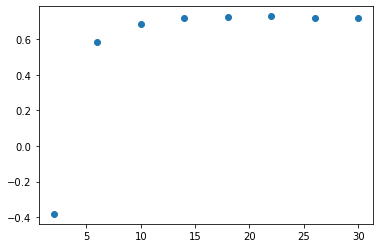

In [28]:

n_bins = np.arange(2, 32, 4)
bins_train_cut, labels = pd.cut(y_train,n_bins,
                                labels=False,
                               retbins=True)

#bins_train_qcut = pd.qcut(y_train,n_bins,  labels=False)
randforest = RandomForestClassifier(n_estimators = 2000)
pipe_forest = make_pipeline(randforest)
scores = []
for bins in n_bins:
    bins_train_cut, train_labels = pd.cut(y_train,bins,
                                labels=False,
                               retbins=True)
    pipe_forest.fit(X_train, bins_train_cut)
    pred = pipe_forest.predict(X_test)
    pred_reg = [train_labels[int(idx)] for idx in pred]
    scr = r2_score(y_test, pred_reg)
    scores.append(scr)

plt.scatter(n_bins, scores);

#### Other models used for Kaggle submission

### Final Evaluation

### Kaggle submission

In [31]:

forest = RandomForestRegressor(n_estimators = 2000,
                              random_state=22)


forest.fit(X_sfs, y)

pred = forest_pipe.predict(X_test_sfs)

df_deliver = pd.DataFrame(pred, columns = ['Rental bikes count'])
df_deliver.to_csv('Deliverable_randforestregressor.csv')


In [ ]:
Stop = time.time()
print(f'Time to run script: {Stop-Start}')